## Problem Definition

We aim to study a **probabilistic optimization problem** within a simulated trading evaluation system (a "funded trader challenge").  
The question is: given a trader with a fixed level of skill (represented by their **Sharpe Ratio**), what is the optimal **annual volatility target** that maximizes their chance of passing or minimizes the expected total cost to pass under specific challenge rules?

---

### Mathematical Formulation

Each simulated challenge follows these conditions:

- Duration: \(T\) trading days  
- Target cumulative return: \(\theta_{profit} > 0\)  
- Maximum allowed daily drawdown: \(\theta_{drawdown} < 0\)  
- Monthly challenge cost: \(C\)  
- Maximum number of restart attempts: \(M\)  

Daily returns are modeled as an i.i.d. random process:

$$
r_t \sim \mathcal{N}\left(
\frac{SR \cdot v_{annual}}{\sqrt{252}},
\frac{v_{annual}^2}{252}
\right)
$$

A challenge is considered **successful** if:

$$
\prod_{t=1}^{T}(1 + r_t) - 1 \ge \theta_{profit}
$$

and all daily returns satisfy \(r_t > \theta_{drawdown}\).

---

## Solution Framework

### 1. Objective

For each pair \((SR, v_{annual})\), simulate repeated challenge sequences to compute:

- \(p_{success}(SR, v)\): probability of passing  
- \(\mathbb{E}[Cost(SR, v)]\): expected total cost to pass  

The optimization goals are:

1. **Maximize success probability**

   $$
   \max_v\ p_{success}(SR, v)
   $$

2. **Minimize expected cost**

   $$
   \min_v\ \mathbb{E}[Cost(SR, v)]
   $$

---

### 2. Methodological Steps

1. **Define parameters**  
   Set ranges for Sharpe Ratio and annual volatility, e.g.  
   \(SR \in [0.5, 3.0]\), \(v_{annual} \in [0.05, 0.3]\).

2. **Monte Carlo simulation**  
   - Generate random daily returns using the model above.  
   - Apply challenge constraints (target profit, drawdown limit, time horizon).  
   - Record outcomes (pass or fail).  
   - Run thousands of trials to estimate success probability and expected cost.

3. **Parameter optimization**  
   - Use an adaptive Bayesian optimizer (e.g., **Optuna**) to search for the best volatility \(v_{annual}\).  
   - The optimizer suggests new samples based on prior evaluation results.  
   - The objective function returns expected cost for minimization.

4. **Evaluation and visualization**  
   - Aggregate the resulting success probabilities and costs.  
   - Plot success and cost curves across volatility.  
   - Identify the volatility level that minimizes expected cost or maximizes success rate.

---

### 3. Expected Outcome

- Reveals an **optimal volatility range** (typically around 12–18%) for any given Sharpe Ratio.  
- Highlights the trade-off:  
  - Low volatility → too conservative, unlikely to reach profit target.  
  - High volatility → higher failure risk due to drawdown constraint.  
- Results show a clear balance point that minimizes expected cost.

---

### 4. Significance

This framework formalizes a **stochastic optimization under risk constraints** problem.  
It provides a reproducible quantitative approach for analyzing proprietary trading evaluation systems, illustrating how skill (Sharpe Ratio) and volatility management jointly determine the probability and cost of success.

## 🧠 Part 1 – Base Version: Monte Carlo Simulation

### 🗣 Concept

Imagine you’re joining a “trading challenge”:

- Each challenge lasts **30 days**  
- The target profit is **+20%**  
- If any single day loses **more than –2%**, you fail  
- Each attempt costs **\$300**

Your skill level is represented by the **Sharpe Ratio (SR)**  
and your risk exposure by **annualized volatility (volatility target)**.

Using **Monte Carlo simulation**, we’ll generate thousands of random challenges to estimate:
- how often you pass (success probability), and
- your average total cost to finally pass once.

This helps answer:
> *Given my Sharpe Ratio, what volatility level is most cost‑effective?*

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_single_trial(SR, vol, days=30, target=0.2, dd_limit=-0.02, seed=None):
    """Simulate a single 30‑day challenge."""
    rng = np.random.default_rng(seed)
    mu_d = (SR * vol) / np.sqrt(252)
    sigma_d = vol / np.sqrt(252)
    daily_returns = rng.normal(mu_d, sigma_d, days)
    if np.any(daily_returns < dd_limit):
        return False
    cum_ret = np.cumprod(1 + daily_returns)[-1] - 1
    return cum_ret >= target

def simulate_monte_carlo(SR, vol, n_trials=5000, days=30, months=12,
                         monthly_cost=300, target=0.2, dd_limit=-0.02, seed=None):
    """Estimate pass probability and expected cost."""
    rng = np.random.default_rng(seed)
    passed, total_cost = 0, 0
    for _ in range(n_trials):
        success, months_used = False, 0
        while months_used < months and not success:
            months_used += 1
            mu_d = (SR * vol) / np.sqrt(252)
            sigma_d = vol / np.sqrt(252)
            daily_returns = rng.normal(mu_d, sigma_d, days)
            if np.any(daily_returns < dd_limit):
                continue
            cum_ret = np.cumprod(1 + daily_returns)[-1] - 1
            success = cum_ret >= target
        total_cost += months_used * monthly_cost
        if success:
            passed += 1
    return passed / n_trials, total_cost / n_trials

# Example
SR_example = 1.5
vol_example = 0.15
p, c = simulate_monte_carlo(SR_example, vol_example)
print(f"Sharpe={SR_example}, Vol={vol_example:.2%}, Pass Rate={p:.2%}, Avg Cost=${c:.2f}")

Sharpe=1.5, Vol=15.00%, Pass Rate=100.00%, Avg Cost=$301.14


## ⚙️ Part 2 – Grid Search Optimization

### 🗣 Concept

The previous example simulated just one case.  
Now we’ll explore *how success rate changes* for different combinations of SR and volatility.

We use a **grid search** — testing multiple combinations across a 2D grid.  
It’s slow but informative and gives us a clear picture of how SR and volatility interact.

A heatmap visualization will help identify where the “sweet spot” lies.

,SR,Vol,PassProb,Cost
0,0.5,0.050000,0.0000,3600.00
1,0.5,0.072727,0.0000,3600.00
2,0.5,0.095455,0.0280,3556.35
3,0.5,0.118182,0.3855,2896.95
4,0.5,0.140909,0.8420,1781.25


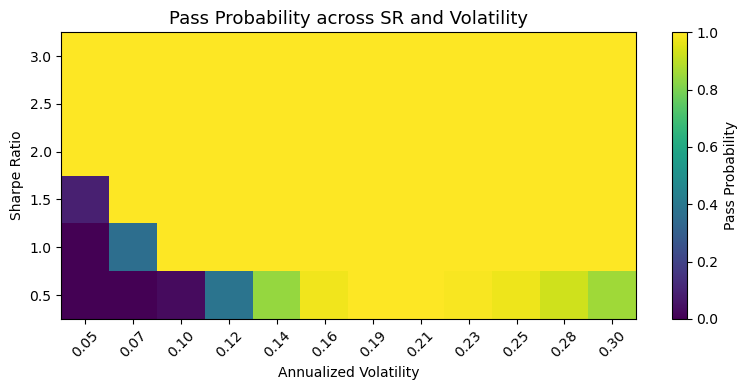

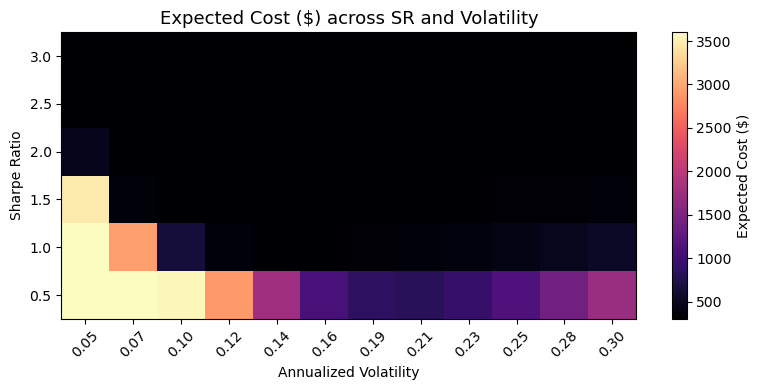

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Monte Carlo simulation functions (reuse from Part 1) ----
def simulate_single_trial(SR, vol, days=30, target=0.2, dd_limit=-0.02, seed=None):
    """Simulate a single 30‑day challenge."""
    rng = np.random.default_rng(seed)
    mu_d = (SR * vol) / np.sqrt(252)
    sigma_d = vol / np.sqrt(252)
    daily_returns = rng.normal(mu_d, sigma_d, days)
    if np.any(daily_returns < dd_limit):
        return False
    cum_ret = np.cumprod(1 + daily_returns)[-1] - 1
    return cum_ret >= target


def simulate_monte_carlo(SR, vol, n_trials=5000, days=30, months=12,
                         monthly_cost=300, target=0.2, dd_limit=-0.02, seed=None):
    """Estimate pass probability and expected cost."""
    rng = np.random.default_rng(seed)
    passed, total_cost = 0, 0
    for _ in range(n_trials):
        success, months_used = False, 0
        while months_used < months and not success:
            months_used += 1
            mu_d = (SR * vol) / np.sqrt(252)
            sigma_d = vol / np.sqrt(252)
            daily_returns = rng.normal(mu_d, sigma_d, days)
            if np.any(daily_returns < dd_limit):
                continue
            cum_ret = np.cumprod(1 + daily_returns)[-1] - 1
            success = cum_ret >= target
        total_cost += months_used * monthly_cost
        if success:
            passed += 1
    return passed / n_trials, total_cost / n_trials


# ---- Grid Search ----
SR_values = np.linspace(0.5, 3.0, 6)      # Sharpe Ratio range
vol_values = np.linspace(0.05, 0.30, 12)  # volatility range

results = []
for SR in SR_values:
    for vol in vol_values:
        p, c = simulate_monte_carlo(SR, vol, n_trials=2000)
        results.append((SR, vol, p, c))

df = pd.DataFrame(results, columns=["SR", "Vol", "PassProb", "Cost"])
display(df.head())

# ---- Pivot for heatmap ----
pivot = df.pivot(index="SR", columns="Vol", values="PassProb")

plt.figure(figsize=(8, 4))
plt.title("Pass Probability across SR and Volatility", fontsize=13)
im = plt.imshow(pivot, cmap="viridis", aspect="auto", origin="lower")
plt.colorbar(im, label="Pass Probability")
plt.xlabel("Annualized Volatility")
plt.ylabel("Sharpe Ratio")
plt.xticks(range(len(pivot.columns)),
           [f"{v:.2f}" for v in pivot.columns],
           rotation=45)
plt.yticks(range(len(pivot.index)),
           [f"{s:.1f}" for s in pivot.index])
plt.tight_layout()
plt.show()

# ---- Optional: plot expected cost ----
pivot_cost = df.pivot(index="SR", columns="Vol", values="Cost")

plt.figure(figsize=(8, 4))
plt.title("Expected Cost ($) across SR and Volatility", fontsize=13)
im2 = plt.imshow(pivot_cost, cmap="magma", aspect="auto", origin="lower")
plt.colorbar(im2, label="Expected Cost ($)")
plt.xlabel("Annualized Volatility")
plt.ylabel("Sharpe Ratio")
plt.xticks(range(len(pivot_cost.columns)),
           [f"{v:.2f}" for v in pivot_cost.columns],
           rotation=45)
plt.yticks(range(len(pivot_cost.index)),
           [f"{s:.1f}" for s in pivot_cost.index])
plt.tight_layout()
plt.show()

## 🚀 Part 3 – Bayesian Optimization (Optuna)

### 🗣 Concept

Grid search works but wastes a lot of time on unpromising regions.  
**Bayesian optimization** (using the `optuna` package) makes the search adaptive —  
it learns from previous trials and suggests new parameter values more intelligently.

Think of it as “smart experimentation” that quickly zooms in on the optimal volatility.

[I 2025-11-18 15:32:59,101] A new study created in memory with name: no-name-b23efedf-8622-4e14-9a2b-0591f12e94a9


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-11-18 15:32:59,143] Trial 0 finished with value: 300.6 and parameters: {'vol': 0.12005961464217137}. Best is trial 0 with value: 300.6.
[I 2025-11-18 15:32:59,160] Trial 1 finished with value: 305.85 and parameters: {'vol': 0.18430707312515904}. Best is trial 0 with value: 300.6.
[I 2025-11-18 15:32:59,271] Trial 2 finished with value: 2527.95 and parameters: {'vol': 0.05463645579573813}. Best is trial 0 with value: 300.6.
[I 2025-11-18 15:32:59,288] Trial 3 finished with value: 303.75 and parameters: {'vol': 0.181204438540088}. Best is trial 0 with value: 300.6.
[I 2025-11-18 15:32:59,303] Trial 4 finished with value: 350.1 and parameters: {'vol': 0.2958652455546217}. Best is trial 0 with value: 300.6.
[I 2025-11-18 15:32:59,320] Trial 5 finished with value: 334.05 and parameters: {'vol': 0.2695825446775595}. Best is trial 0 with value: 300.6.
[I 2025-11-18 15:32:59,335] Trial 6 finished with value: 327.6 and parameters: {'vol': 0.25042390926460195}. Best is trial 0 with value

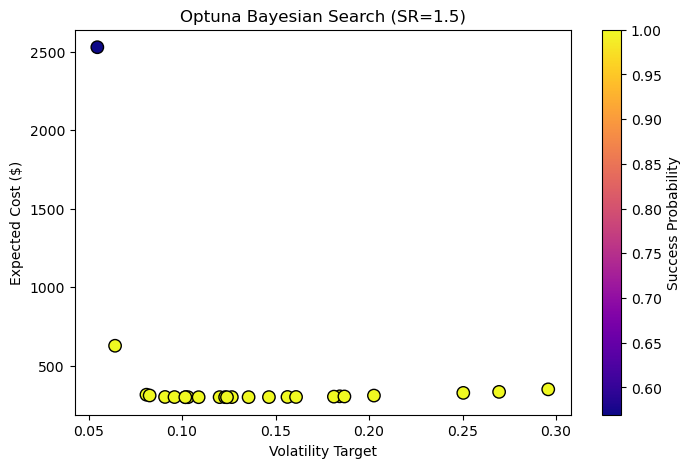

In [12]:
import optuna

SR_fixed = 1.5  # fixed Sharpe Ratio for optimization

def objective(trial):
    vol = trial.suggest_float("vol", 0.05, 0.3)
    p, c = simulate_monte_carlo(SR_fixed, vol, n_trials=2000)
    trial.set_user_attr("success_prob", p)
    return c  # minimize expected cost

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

best = study.best_trial
print(f"Best Volatility = {best.params['vol']:.3f}")
print(f"Expected Cost = ${best.value:.2f}")
print(f"Pass Rate = {best.user_attrs['success_prob']:.2%}")

# Visualization
vols = [t.params["vol"] for t in study.trials]
costs = [t.value for t in study.trials]
probs = [t.user_attrs.get("success_prob", np.nan) for t in study.trials]

plt.figure(figsize=(8,5))
plt.scatter(vols, costs, c=probs, cmap="plasma", s=80, edgecolor="k")
plt.colorbar(label="Success Probability")
plt.xlabel("Volatility Target")
plt.ylabel("Expected Cost ($)")
plt.title(f"Optuna Bayesian Search (SR={SR_fixed})")
plt.show()

## 🔀 Part 4 – Multi‑Objective Optimization

### 🗣 Concept

In reality, we want **two things** at once:
- a higher **success probability**, and  
- a lower **expected cost**.

These objectives compete with each other — more volatility can improve success but also increase drawdown failures.

We can visualize this balance using **multi‑objective optimization**, discovering the **Pareto front**:  
the set of all combinations where you cannot improve one side without worsening the other.

[I 2025-11-18 15:33:24,492] A new study created in memory with name: no-name-76781b91-1480-4f4a-8dd6-4e56915f0649


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-18 15:33:24,546] Trial 0 finished with values: [-0.9986666666666667, 755.4] and parameters: {'SR': 0.8307859536657212, 'vol': 0.11038877099233523}.
[I 2025-11-18 15:33:24,558] Trial 1 finished with values: [-1.0, 307.4] and parameters: {'SR': 1.3505195557935328, 'vol': 0.17700769946475986}.
[I 2025-11-18 15:33:24,571] Trial 2 finished with values: [-1.0, 319.2] and parameters: {'SR': 1.2022454338335526, 'vol': 0.19031585486147234}.
[I 2025-11-18 15:33:24,585] Trial 3 finished with values: [-1.0, 300.0] and parameters: {'SR': 2.1856888373941428, 'vol': 0.14468180595839436}.
[I 2025-11-18 15:33:24,597] Trial 4 finished with values: [-1.0, 300.8] and parameters: {'SR': 2.0235680722702982, 'vol': 0.18576133678527912}.
[I 2025-11-18 15:33:24,610] Trial 5 finished with values: [-1.0, 305.0] and parameters: {'SR': 1.6075027714858945, 'vol': 0.08042412482348683}.
[I 2025-11-18 15:33:24,621] Trial 6 finished with values: [-1.0, 300.2] and parameters: {'SR': 2.9695792980846547, 'vol':

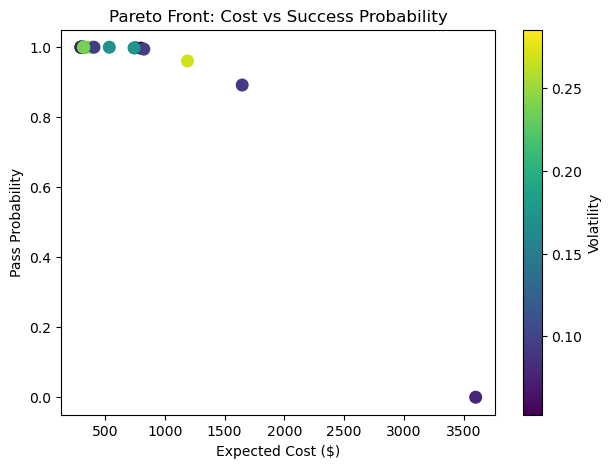

In [13]:
def objective_multi(trial):
    SR = trial.suggest_float("SR", 0.5, 3.0)
    vol = trial.suggest_float("vol", 0.05, 0.30)
    p, c = simulate_monte_carlo(SR, vol, n_trials=1500)
    return -p, c  # Optuna minimizes both -> negate p (maximize success)

study_multi = optuna.create_study(directions=["minimize", "minimize"])
study_multi.optimize(objective_multi, n_trials=40, show_progress_bar=True)

# Collect results for visualization
S, V, P, C = [], [], [], []
for t in study_multi.trials:
    if t.values:
        S.append(t.params["SR"])
        V.append(t.params["vol"])
        P.append(-t.values[0])
        C.append(t.values[1])

plt.figure(figsize=(7,5))
plt.scatter(C, P, c=V, cmap="viridis", s=70)
plt.xlabel("Expected Cost ($)")
plt.ylabel("Pass Probability")
plt.title("Pareto Front: Cost vs Success Probability")
plt.colorbar(label="Volatility")
plt.show()

## 📊 Summary

| Section | Method | Question Answered | Strength |
|----------|---------|------------------|-----------|
| **Part 1** | Monte Carlo Simulation | “If my SR = 1.5 and Vol = 15%, what’s my success rate?” | Simple and transparent |
| **Part 2** | Grid Search | “How do SR and volatility interact?” | Easy to visualize trends |
| **Part 3** | Bayesian Optimization (Optuna) | “What’s the most efficient volatility target?” | Fast, adaptive tuning |
| **Part 4** | Multi‑Objective Optimization | “How do cost and success trade‑offs look?” | Shows Pareto‑efficient front |